# LeNet Lab Solution
![LeNet Architecture](lenet.png)
Source: Yan LeCun

## Load Data

Lets load the MNIST data, which comes pre-loaded with TensorFlow.

In [1]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", reshape=False)
X_train, y_train           = mnist.train.images, mnist.train.labels
X_validation, y_validation = mnist.validation.images, mnist.validation.labels
X_test, y_test             = mnist.test.images, mnist.test.labels

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set:       {} samples".format(len(X_test)))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz

Image Shape: (28, 28, 1)

Training Set:   55000 samples
Validation Set: 5000 samples
Test Set:       10000 samples


The MNIST data that TensorFlow pre-loads comes as 28x28x1 images.

However, the LeNet architecture only accepts 32x32xC images, where C is the number of color channels.

In order to reformat the MNIST data into a shape that LeNet will accept, we pad the data with two rows of zeros on the top and bottom, and two columns of zeros on the left and right (28+2+2 = 32).


In [2]:
import numpy as np

# Pad images with 0s
X_train      = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_validation = np.pad(X_validation, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_test       = np.pad(X_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')
    
print("Updated Image Shape: {}".format(X_train[0].shape))

Updated Image Shape: (32, 32, 1)


## Visualize Data

View a sample from the dataset.



9


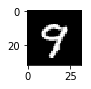

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

## Preprocess Data

Shuffle the training data.



In [4]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

## Setup TensorFlow
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.



In [5]:
import tensorflow as tf

EPOCHS = 10
BATCH_SIZE = 128

## LeNet-5
[LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.


### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.

### Architecture
**Layer 1: Convolutional.** The output shape is 28x28x6.

**Activation.** Let's use ReLu activation function.

**Pooling.** The output shape is 14x14x6.

**Layer 2: Convolutional.** The output shape is 10x10x16.

**Activation.** Let's use ReLu activation function.

**Pooling.** The output shape is 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D.

**Layer 3: Fully Connected.** This one have 120 outputs.

**Activation.** Let's use ReLu activation function.

**Layer 4: Fully Connected.** This one have 84 outputs.

**Activation.** Let's use ReLu activation function.

**Layer 5: Fully Connected (Logits).** This one have 10 outputs.

### Output
Return the result of the 2nd fully connected layer.

In [6]:
from tensorflow.contrib.layers import flatten

def conv2d(x, W, b, strides=1, padding='VALID'):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1],
                     padding=padding)
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2, padding='VALID'):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1],
                         strides=[1, k, k, 1],
                         padding=padding)
def fc_relu(x, W, b):
    x = tf.add(tf.matmul(x, W), b)
    return tf.nn.relu(x)


def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    weights = {
        'wc1': tf.Variable(tf.truncated_normal(shape=(5,5,1,6), mean = mu, stddev = sigma)),
        'wc2': tf.Variable(tf.truncated_normal(shape=(5,5,6,16), mean = mu, stddev = sigma)),
        'wfc1': tf.Variable(tf.truncated_normal(shape=(5*5*16,120), mean = mu, stddev = sigma)),
        'wfc2': tf.Variable(tf.truncated_normal(shape=(120,84), mean = mu, stddev = sigma)),
        'out': tf.Variable(tf.truncated_normal(shape=(84,10), mean = mu, stddev = sigma))
    }
    
    biases = {
        'bc1': tf.Variable(tf.zeros(6)),
        'bc2': tf.Variable(tf.zeros(16)),
        'bfc1': tf.Variable(tf.zeros(120)),
        'bfc2': tf.Variable(tf.zeros(84)),
        'out': tf.Variable(tf.zeros(10))
    }
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    # Activation.
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    c1 = conv2d(x, weights['wc1'], biases['bc1'], padding='VALID')       
    c1 = maxpool2d(c1, k=2, padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.    
    # Activation.
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    c2 = conv2d(c1, weights['wc2'], biases['bc2'], padding='VALID')       
    c2 = maxpool2d(c2, k=2, padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    c2_flat = flatten(c2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.    
    # Activation.
    fc1 = fc_relu(c2_flat, weights['wfc1'], biases['bfc1'])       

    # Layer 4: Fully Connected. Input = 120. Output = 84.    
    # Activation.
    fc2 = fc_relu(fc1, weights['wfc2'], biases['bfc2'])

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    logits = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    
    return logits

## Features and Labels
Train LeNet to classify [MNIST](http://yann.lecun.com/exdb/mnist/) data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.



In [7]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 10)

## Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.



In [8]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.



In [9]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.



In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.973

EPOCH 2 ...
Validation Accuracy = 0.983

EPOCH 3 ...
Validation Accuracy = 0.983

EPOCH 4 ...
Validation Accuracy = 0.985

EPOCH 5 ...
Validation Accuracy = 0.986

EPOCH 6 ...
Validation Accuracy = 0.987

EPOCH 7 ...
Validation Accuracy = 0.991

EPOCH 8 ...
Validation Accuracy = 0.988

EPOCH 9 ...
Validation Accuracy = 0.991

EPOCH 10 ...
Validation Accuracy = 0.993

Model saved


## Evaluate the Model
Once we are completely satisfied with the model, we evaluate the performance of the model on the test set.

We test it only once!

If we were to measure the performance of our trained model on the test set, then improve our model, and then measure the performance of our model on the test set again, that would invalidate our test results. We wouldn't get a true measure of how well our model would perform against real data.


In [11]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.990
